# Load data

In [2]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import sys
print(sys.path)
sys.path.append('c:/Users/bryan/fastshap')

['c:\\Users\\bryan\\fastshap\\notebooks', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\python310.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\bryan\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0', '', 'C:\\Users\\bryan\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages', 'C:\\Users\\bryan\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32', 'C:\\Users\\bryan\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32\\lib', 'C:\\Users\\bryan\\AppData\\Loca

# Train model with missingness

In [5]:
import torch
import torch.nn as nn
import os.path
from resnet import ResNet18
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [6]:
# Select device
device = torch.device('cuda')

In [7]:
# Check for model
if os.path.isfile('cifar missingness.pt'):
    print('Loading saved model')
    model = torch.load('cifar missingness.pt').to(device)
    imputer = ImageSurrogate(model, width=32, height=32, superpixel_size=2)

else:
    # Create model
    model = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)
    
    # familiariaze with DataLoader
    # Set up surrogate wrapper (although this is not a surrogate model)
    imputer = ImageSurrogate(model, width=32, height=32, superpixel_size=2)

    # Train
    imputer.train(train_set,
                  val_set,
                  batch_size=256,
                  max_epochs=100,
                  loss_fn=nn.CrossEntropyLoss(),
                  lookback=10,
                  bar=True,
                  verbose=True)
    
    # Save model
    model.cpu()
    torch.save(model, 'cifar missingness.pt')
    model.to(device)

Loading saved model


# Train FastSHAP

In [8]:
from unet import UNet
from fastshap import FastSHAP

In [9]:
# Check for model
if os.path.isfile('cifar missingness explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar missingness explainer.pt').to(device)
    fastshap = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    # the train and val set are just the CIFAR dataset
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'cifar missingness explainer.pt')
    explainer.to(device)

Loading saved explainer model


# Visualize results

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [10]:
def calculate_exclusion(values, samples, targets):
    #del mask
    # print(len(targets))
    # print(values.shape)
    targets = torch.tensor(targets)
    inclusion_auc = []
    sorted_val = torch.zeros((len(values), 256))
    for i in range(len(values)):
        sorted_val[i] = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]

    inclusion_percentages = torch.linspace(0, 1, len(sorted_val[0])+1)
    # print(sorted_val)
    # print(inclusion_percentages)
    # del e
    top1_accuracies = []
    values = values[torch.arange(len(values)), targets]
    for threshold in inclusion_percentages:
        print(threshold)
        # Create binary mask for the top features
        mask = (values >= sorted_val[:,int(threshold * (len(sorted_val[0])-1))].unsqueeze(1).unsqueeze(2))
        # print(threshold)
        #print(f'{threshold}:{mask}')
        mask = mask.reshape(-1)
        # print(mask.shape)
        mask = mask.view((len(values), 256))
        S = torch.ones(len(values), imputer.num_players, device=device)
        S[mask] = 0
        #print(S)
        output = imputer(samples.to(device), S).softmax(dim=1).cpu().data
        
        # Compute top-1 accuracy
        _, predicted = torch.max(output, dim=1)
        predicted = torch.tensor(predicted)
        #print(predicted)
        correct = (predicted == targets).sum().item()
        accuracy = correct / len(values)
        
        top1_accuracies.append(accuracy)
        del S, output, predicted, correct, accuracy, mask
        
    # Compute AUC for inclusion percentages vs. top-1 accuracies curve
    top1_accuracies=torch.tensor(top1_accuracies)
    auc = torch.trapz(top1_accuracies, inclusion_percentages)
    inclusion_auc.append(auc)

    # Compute average inclusion AUC across all instances
    average_auc = torch.mean(torch.tensor(inclusion_auc))
    #print(inclusion_auc)
    print("Average exclusion AUC:", average_auc.item())
    del top1_accuracies, inclusion_auc, sorted_val, values
    return average_auc

In [11]:
def calculate_inclusion(values, samples, targets):
    targets = torch.tensor(targets)
    inclusion_auc = []
    sorted_val = torch.zeros((len(values), 256))
    for i in range(len(values)):
        sorted_val[i] = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]

    inclusion_percentages = torch.linspace(0, 1, len(sorted_val[0])+1)
    # print(sorted_val)
    # print(inclusion_percentages)
    # del e
    top1_accuracies = []
    values = values[torch.arange(len(values)), targets]
    for threshold in inclusion_percentages:
        print(threshold)
        # Create binary mask for the top features
        mask = (values < sorted_val[:,int(threshold * (len(sorted_val[0])-1))].unsqueeze(1).unsqueeze(2))
        # print(threshold)
        #print(f'{threshold}:{mask}')
        mask = mask.reshape(-1)
        # print(mask.shape)
        mask = mask.view((len(values), 256))
        S = torch.ones(len(values), imputer.num_players, device=device)
        S[mask] = 0
        #print(S)
        output = imputer(samples.to(device), S).softmax(dim=1).cpu().data
        
        # Compute top-1 accuracy
        _, predicted = torch.max(output, dim=1)
        predicted = torch.tensor(predicted)
        #print(predicted)
        correct = (predicted == targets).sum().item()
        accuracy = correct / len(values)
        
        top1_accuracies.append(accuracy)
        del S, output, predicted, correct, accuracy, mask
    # Compute AUC for inclusion percentages vs. top-1 accuracies curve
    top1_accuracies=torch.tensor(top1_accuracies)
    auc = torch.trapz(top1_accuracies, inclusion_percentages)
    inclusion_auc.append(auc)

    # Compute average inclusion AUC across all instances
    average_auc = torch.mean(torch.tensor(inclusion_auc))
    #print(inclusion_auc)
    print("Average inclusion AUC:", average_auc.item())
    del top1_accuracies, inclusion_auc, sorted_val, values
    return average_auc

In [ ]:
# Select one image from each class
# import torch
# foo = torch.tensor([1,2,3])
# foo = foo.to('cuda')
# del fastshap
# import gc

# gc.collect()
# del S, output, predicted, correct, accuracy, mask
# del top1_accuracies, inclusion_auc, sorted_val, values
# torch.cuda.empty_cache()
dset = val_set
samples = np.array(dset.data)
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*list(dset))
x = torch.stack(x)

# # Get explanations
# values = torch.tensor(fastshap.shap_values(x.to(device)))
# print(values.shape)
# sorted_val = []
# sorted_masks = []
# for i in range(len(values)):
#     sorted_val.append(values[i][i].flatten())
#     sorted_val[i] = sorted(sorted_val[i], reverse=True)
#     temp_coord = []
#     for j in range(len(sorted_val[i])):
#         mask = (values[i][i] == sorted_val[i][j])
#         #print(mask)
#         temp_coord.append(mask)
#     sorted_masks.append(temp_coord)
#     print(len(sorted_val))

# eval_x = x
# print(eval_x.shape)
# top1_accuracies = []
# for i in range(len(sorted_val[i])):
#     for j in range(len(sorted_val)):
#         mask = sorted_masks[j][0]
#         print(mask)
#         downsampled_tensor = F.interpolate(eval_x, (16, 16), mode='bilinear', align_corners=False)
#         downsampled_tensor[j,:,mask] = 100
#         eval_x = F.interpolate(downsampled_tensor, (32, 32), mode='bilinear', align_corners=False)

import torch
import torch.nn.functional as F

# Assuming values is your SHAP values tensor with shape (batch_size, num_classes, num_features, height, width)
#values = torch.tensor(fastshap.shap_values(x.to(device)))
#values_val = torch.tensor(fastshap.shap_values(x.to(device)))

values_val = torch.load('values_val.pt')
print("Shape of SHAP values tensor:", values_val.shape)
# average_exclusion = 0
# for i in range(0, 10000, 1000):
#     print(i)
#     average_exclusion += calculate_exclusion(values_val[i:i+1000], x[i:i+1000], y[i:i+1000])
# print(average_exclusion / 10)

average_inclusion = 0
for i in range(0, 10000, 2000):
    print(i)
    average_inclusion += calculate_inclusion(values_val[i:i+2000], x[i:i+2000], y[i:i+2000])
print(average_inclusion / 5)




# basically get the classification accuracy of the imputer model whenever as you remove the top included pixel features and map this
# do this for all the images
# we have the way to get top pixel imp values at the top



# Get predictions
# pred = imputer(
#     x.to(device),
#     torch.ones(num_classes, imputer.num_players, device=device)
# ).softmax(dim=1).cpu().data.numpy()

# fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

# for row in range(num_classes):
#     # Image
#     classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
#     mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
#     std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
#     im = x[row].numpy() * std + mean
#     im = im.transpose(1, 2, 0).astype(float)
#     im = np.clip(im, a_min=0, a_max=1)
#     axarr[row, 0].imshow(im, vmin=0, vmax=1)
#     axarr[row, 0].set_xticks([])
#     axarr[row, 0].set_yticks([])
#     axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
#     # Explanations
#     m = np.abs(values[row]).max()
#     for col in range(num_classes):
#         axarr[row, col + 1].imshow(values_val[row, col], cmap='seismic', vmin=-m, vmax=m)
#         axarr[row, col + 1].set_xticks([])
#         axarr[row, col + 1].set_yticks([])
#         if col == y[row]:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
#         else:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
#         # Class labels
#         if row == 0:
#             axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

# plt.tight_layout()
# plt.show()

del values_val

Shape of SHAP values tensor: torch.Size([10000, 10, 16, 16])
0
tensor(0.)


C:\Users\bryan\AppData\Local\Temp\ipykernel_33612\2082005005.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = torch.tensor(predicted)


tensor(0.0039)
tensor(0.0078)
tensor(0.0117)
tensor(0.0156)
tensor(0.0195)
tensor(0.0234)
tensor(0.0273)
tensor(0.0312)
tensor(0.0352)
tensor(0.0391)
tensor(0.0430)
tensor(0.0469)
tensor(0.0508)
tensor(0.0547)
tensor(0.0586)
tensor(0.0625)
tensor(0.0664)
tensor(0.0703)
tensor(0.0742)
tensor(0.0781)
tensor(0.0820)
tensor(0.0859)
tensor(0.0898)
tensor(0.0938)
tensor(0.0977)
tensor(0.1016)
tensor(0.1055)
tensor(0.1094)
tensor(0.1133)
tensor(0.1172)
tensor(0.1211)
tensor(0.1250)
tensor(0.1289)
tensor(0.1328)
tensor(0.1367)
tensor(0.1406)
tensor(0.1445)
tensor(0.1484)
tensor(0.1523)
tensor(0.1562)
tensor(0.1602)
tensor(0.1641)
tensor(0.1680)
tensor(0.1719)
tensor(0.1758)
tensor(0.1797)
tensor(0.1836)
tensor(0.1875)
tensor(0.1914)
tensor(0.1953)
tensor(0.1992)
tensor(0.2031)
tensor(0.2070)
tensor(0.2109)
tensor(0.2148)
tensor(0.2188)
tensor(0.2227)
tensor(0.2266)
tensor(0.2305)
tensor(0.2344)
tensor(0.2383)
tensor(0.2422)
tensor(0.2461)
tensor(0.2500)
tensor(0.2539)
tensor(0.2578)
tensor(0.2

In [ ]:
# def calculate_exclusion(values, samples, targets):
#     inclusion_auc = []

#     for i in range(len(values)):
#         # Sort SHAP values for each instance
#         print(i)
#         sorted_val = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]
#         #print(sorted_val)
        
#         # Compute inclusion percentage thresholds
#         inclusion_percentages = torch.linspace(0, 1, len(sorted_val) + 1)
#         #print(inclusion_percentages)
        
#         top1_accuracies = []
#         # Iterate over inclusion percentage thresholds

#         for threshold in inclusion_percentages:
#             # Create binary mask for the top features
#             # print(values[i, targets[i]])
#             #print(f'{i}:{sorted_val[int(threshold * (len(sorted_val)-1))]}')
#             mask = values[i, targets[i]] >= sorted_val[int(threshold * (len(sorted_val)-1))]
#             mask = mask.reshape(-1)
#             mask = mask.view((1, 256))
#             print(mask)
            
#             # Upsample binary mask if necessary
#             #mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), (32, 32), mode='nearest').bool()
            
#             # Apply mask to input image
#             # masked_image = x.clone()[i]
#             # masked_image[:, mask[0][0]] = 100  # Example modification
            
#             # Downsample masked image (if needed) and perform inference
#             #downsampled_image = F.interpolate(masked_image, (16, 16), mode='bilinear', align_corners=False)
#             S = torch.ones(1, imputer.num_players, device=device)
#             S[mask] = 0
#             #print(S)
#             output = imputer(samples[i].to(device), S).softmax(dim=1).cpu().data
            
#             # Compute top-1 accuracy
#             _, predicted = torch.max(output, dim=1)
#             #print(predicted)
#             correct = (predicted == targets[i]).sum().item()
#             accuracy = correct
            
#             top1_accuracies.append(accuracy)
#             del S, mask, accuracy
        
#         # Compute AUC for inclusion percentages vs. top-1 accuracies curve
#         top1_accuracies=torch.tensor(top1_accuracies)
#         auc = torch.trapz(top1_accuracies, inclusion_percentages)
#         inclusion_auc.append(auc)

#     # Compute average inclusion AUC across all instances
#     average_auc = torch.mean(torch.tensor(inclusion_auc))
#     #print(inclusion_auc)
#     print("Average exclusion AUC:", average_auc.item())
#     del top1_accuracies, sorted_val, inclusion_percentages, inclusion_auc

In [ ]:
# def calculate_inclusion(values, samples, targets):
#     inclusion_auc = []

#     for i in range(len(values)):
#         # Sort SHAP values for each instance
#         print(i)
#         sorted_val = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]
#         #print(sorted_val)
        
#         # Compute inclusion percentage thresholds
#         inclusion_percentages = torch.linspace(0, 1, len(sorted_val) + 1)
#         #print(inclusion_percentages)
        
#         top1_accuracies = []
#         # Iterate over inclusion percentage thresholds

#         for threshold in inclusion_percentages:
#             # Create binary mask for the top features
#             # what I changed for exclusion is that there is a < instead of a >=
#             mask = values[i, targets[i]] < sorted_val[int(threshold * (len(sorted_val)-1))]
#             mask = mask.reshape(-1)
#             mask = mask.view((1, 256))
#             #print(mask.shape)
            
#             # Upsample binary mask if necessary
#             #mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), (32, 32), mode='nearest').bool()
            
#             # Apply mask to input image
#             # masked_image = x.clone()[i]
#             # masked_image[:, mask[0][0]] = 100  # Example modification
            
#             # Downsample masked image (if needed) and perform inference
#             #downsampled_image = F.interpolate(masked_image, (16, 16), mode='bilinear', align_corners=False)
#             S = torch.ones(1, imputer.num_players, device=device)
#             S[mask] = 0
#             #print(S)
#             output = imputer(samples[i].to(device), S).softmax(dim=1).cpu().data
            
#             # Compute top-1 accuracy
#             _, predicted = torch.max(output, dim=1)
#             #print(predicted)
#             correct = (predicted == targets[i]).sum().item()
#             accuracy = correct
            
#             top1_accuracies.append(accuracy)
        
#         # Compute AUC for inclusion percentages vs. top-1 accuracies curve
#         top1_accuracies=torch.tensor(top1_accuracies)
#         auc = torch.trapz(top1_accuracies, inclusion_percentages)
#         inclusion_auc.append(auc)

#     # Compute average inclusion AUC across all instances
#     average_auc = torch.mean(torch.tensor(inclusion_auc))
#     #print(inclusion_auc)
#     print("Average inclusion AUC:", average_auc.item())

Shape of SHAP values tensor: torch.Size([10, 10, 16, 16])
0
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,

NameError: name 'values' is not defined

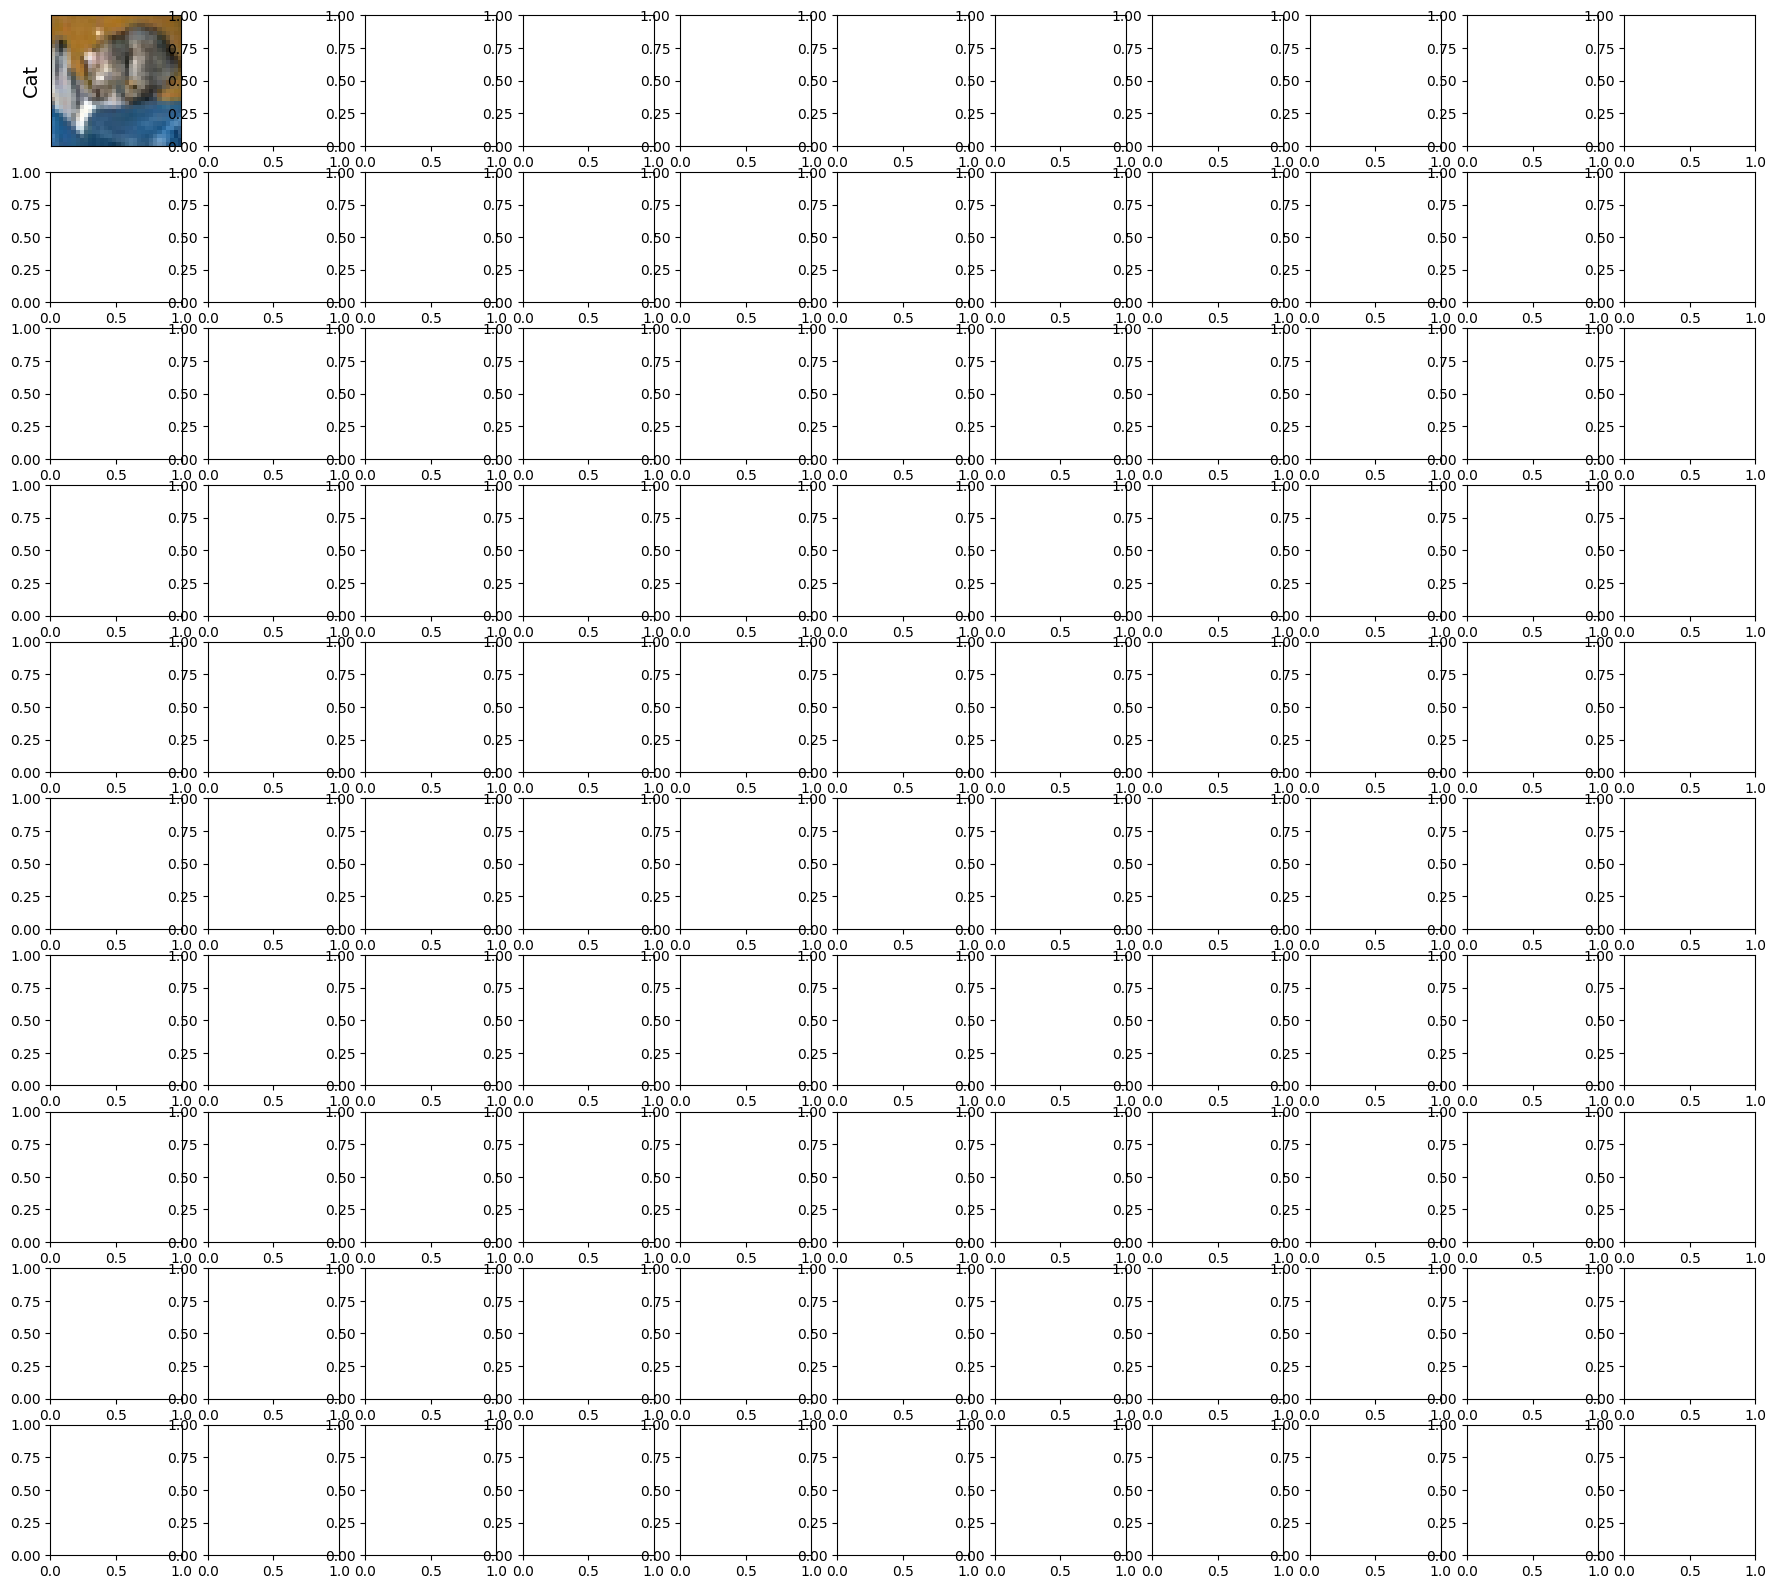

In [25]:
# # Select one image from each class
# # import torch
# # foo = torch.tensor([1,2,3])
# # foo = foo.to('cuda')
# # del fastshap
# # import gc

# # gc.collect()

# # torch.cuda.empty_cache()

# dset = val_set
# samples = np.array(dset.data)
# targets = np.array(dset.targets)
# num_classes = targets.max() + 1
# inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
# inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
# x, y = zip(*list(dset[i] for i in range(10)))
# x = torch.stack(x)

# # # Get explanations
# # values = torch.tensor(fastshap.shap_values(x.to(device)))
# # print(values.shape)
# # sorted_val = []
# # sorted_masks = []
# # for i in range(len(values)):
# #     sorted_val.append(values[i][i].flatten())
# #     sorted_val[i] = sorted(sorted_val[i], reverse=True)
# #     temp_coord = []
# #     for j in range(len(sorted_val[i])):
# #         mask = (values[i][i] == sorted_val[i][j])
# #         #print(mask)
# #         temp_coord.append(mask)
# #     sorted_masks.append(temp_coord)
# #     print(len(sorted_val))

# # eval_x = x
# # print(eval_x.shape)
# # top1_accuracies = []
# # for i in range(len(sorted_val[i])):
# #     for j in range(len(sorted_val)):
# #         mask = sorted_masks[j][0]
# #         print(mask)
# #         downsampled_tensor = F.interpolate(eval_x, (16, 16), mode='bilinear', align_corners=False)
# #         downsampled_tensor[j,:,mask] = 100
# #         eval_x = F.interpolate(downsampled_tensor, (32, 32), mode='bilinear', align_corners=False)

# import torch
# import torch.nn.functional as F

# # Assuming values is your SHAP values tensor with shape (batch_size, num_classes, num_features, height, width)
# #values = torch.tensor(fastshap.shap_values(x.to(device)))
# values_val = torch.tensor(fastshap.shap_values(x.to(device)))
# print("Shape of SHAP values tensor:", values_val.shape)

# calculate_exclusion(values_val, x, y)
# #calculate_inclusion(values_val, x, y)




# # basically get the classification accuracy of the imputer model whenever as you remove the top included pixel features and map this
# # do this for all the images
# # we have the way to get top pixel imp values at the top



# # Get predictions
# pred = imputer(
#     x.to(device),
#     torch.ones(num_classes, imputer.num_players, device=device)
# ).softmax(dim=1).cpu().data.numpy()

# fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

# for row in range(num_classes):
#     # Image
#     classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
#     mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
#     std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
#     im = x[row].numpy() * std + mean
#     im = im.transpose(1, 2, 0).astype(float)
#     im = np.clip(im, a_min=0, a_max=1)
#     axarr[row, 0].imshow(im, vmin=0, vmax=1)
#     axarr[row, 0].set_xticks([])
#     axarr[row, 0].set_yticks([])
#     axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
#     # Explanations
#     m = np.abs(values[row]).max()
#     for col in range(num_classes):
#         axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
#         axarr[row, col + 1].set_xticks([])
#         axarr[row, col + 1].set_yticks([])
#         if col == y[row]:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
#         else:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
#         # Class labels
#         if row == 0:
#             axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

# plt.tight_layout()
# plt.show()

# del values_val

In [10]:
num_shadow = 3
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)
# random_indices = np.random.default_rng(seed=None).permutation(len(train_set))
random_indices = torch.randperm(len(train_set))
selected_i = random_indices[:30000]
n_selected_i = random_indices[30000:]
shadow_set = torch.utils.data.Subset(train_set, selected_i)
target_set = torch.utils.data.Subset(train_set, n_selected_i)

explainer4 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)
fastshap_target_model = FastSHAP(explainer4, imputer, link=nn.LogSoftmax(dim=1))

fastshap_target_set = DatasetInputOnly(target_set)
fastshap_val = DatasetInputOnly(val_set)

torch.save(target_set, 'target_set.pt')
torch.save(val_set, 'val_set.pt')

fastshap_target_model.train(
    fastshap_target_set,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)

explainer4.cpu()
torch.save(explainer4, 'cifar target.pt')
explainer4.to(device)

Files already downloaded and verified


Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#del explainer4
random_indices = torch.randperm(len(shadow_set))
first_i = random_indices[:10000]
second_i = random_indices[10000:20000]
third_i = random_indices[20000:]
shadow_set1 = torch.utils.data.Subset(shadow_set, first_i)
shadow_set2 = torch.utils.data.Subset(shadow_set, second_i)
shadow_set3 = torch.utils.data.Subset(shadow_set, third_i)

# Set up explainer model
explainer1 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)
explainer2 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)
explainer3 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

# Set up FastSHAP object
fastshap_shadow1 = FastSHAP(explainer1, imputer, link=nn.LogSoftmax(dim=1))
fastshap_shadow2 = FastSHAP(explainer2, imputer, link=nn.LogSoftmax(dim=1))
fastshap_shadow3 = FastSHAP(explainer3, imputer, link=nn.LogSoftmax(dim=1))


# Set up datasets
# the train and val set are just the CIFAR dataset
fastshap_train1 = DatasetInputOnly(shadow_set1)
fastshap_train2 = DatasetInputOnly(shadow_set2)
fastshap_train3 = DatasetInputOnly(shadow_set3)
fastshap_val = DatasetInputOnly(val_set)

torch.save(shadow_set1, "shadow_set1.pt")
torch.save(shadow_set2, "shadow_set2.pt")
torch.save(shadow_set3, "shadow_set3.pt")

# Train
fastshap_shadow1.train(
    fastshap_train1,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)

fastshap_shadow2.train(
    fastshap_train2,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)

fastshap_shadow3.train(
    fastshap_train3,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)



# Save explainer
explainer1.cpu()
torch.save(explainer1, 'cifar missingness explainer1.pt')
explainer1.to(device)

explainer2.cpu()
torch.save(explainer2, 'cifar missingness explainer2.pt')
explainer2.to(device)

explainer3.cpu()
torch.save(explainer3, 'cifar missingness explainer3.pt')
explainer3.to(device)

In [15]:
def evaluation(values, x, y):
    average_exclusion = 0
    average_exclusion += calculate_exclusion(values[:2000], x[:2000], y[:2000])
    # for i in range(0, 10000, 2000):
    #     print(i)
    #     average_exclusion += calculate_exclusion(values[i:i+2000], x[i:i+2000], y[i:i+2000])
    # print(f'total average exclusion: {average_exclusion / 5}')

    average_inclusion = 0
    average_inclusion += calculate_inclusion(values[:2000], x[:2000], y[:2000])
    # for i in range(0, 10000, 2000):
    #     print(i)
    #     average_inclusion += calculate_inclusion(values[i:i+2000], x[i:i+2000], y[i:i+2000])
    # print(f'total average inclusion: {average_inclusion / 5}')

In [10]:
val_set = torch.load('val_set.pt')
dset = val_set
samples = np.array(dset.data)
targets = np.array(dset.targets)
x, y = zip(*list(dset))
x = torch.stack(x)
#values = torch.tensor(fastshap.shap_values(x.to(device)))
explainer = torch.load('cifar target.pt').to(device)
fastshap_target_model = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))
values_val_target = torch.tensor(fastshap_target_model.shap_values(x.to(device)))
torch.save(values_val_target, 'values_val_target.pt')
del fastshap_target_model

explainer = torch.load('cifar missingness explainer1.pt').to(device)
fastshap_shadow1 = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

explainer = torch.load('cifar missingness explainer2.pt').to(device)
fastshap_shadow2 = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

explainer = torch.load('cifar missingness explainer3.pt').to(device)
fastshap_shadow3 = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

values_val_shadow1 = torch.tensor(fastshap_shadow1.shap_values(x.to(device)))
torch.save(values_val_shadow1, 'values_val_shadow1.pt')
del fastshap_shadow1
values_val_shadow2 = torch.tensor(fastshap_shadow2.shap_values(x.to(device)))
torch.save(values_val_shadow2, 'values_val_shadow2.pt')
del fastshap_shadow2
values_val_shadow3 = torch.tensor(fastshap_shadow3.shap_values(x.to(device)))
torch.save(values_val_shadow3, 'values_val_shadow3.pt')
del fastshap_shadow3

NameError: name 'val_set' is not defined

In [ ]:
print("Shape of SHAP values tensor:", values_val_target.shape)
evaluation(values_val_target, x, y)
evaluation(values_val_shadow1, x, y)
evaluation(values_val_shadow2, x, y)
evaluation(values_val_shadow3, x, y)

In [ ]:
shadow_set1 = torch.load('shadow_set1.pt')
explainer1 = torch.load('cifar missingness explainer1.pt').to(device)
shadow_set2 = torch.load('shadow_set2.pt')
shadow_set3 = torch.load('shadow_set3.pt')

In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)
data = torch.tensor(train_set.data)
labels = torch.zeros((20000), dtype=torch.float)
targets = train_set.targets
x, y = zip(*list(train_set))
x = torch.stack(x)

# Set labels to True for elements in the subset
labels1 = labels
labels2 = labels
labels3 = labels

# Shadow Model 1 Training Set
shadow_set1 = torch.load('shadow_set1.pt')
explainer1 = torch.load('cifar missingness explainer1.pt').to(device)
fastshap_shadow1 = FastSHAP(explainer1, imputer, link=nn.LogSoftmax(dim=1))
in_set = shadow_set1
x, targets = zip(*list(in_set))
x = torch.stack(x)
values = []
values_shadow1 = torch.load('values_shadow1_training.pt')
values.append(torch.tensor(values_shadow1))
out_set = val_set
values.append(torch.load('values_val_shadow1.pt'))
_, y = zip(*list(out_set))
values_shadow1 = torch.cat(values, dim=0)
temp = []
for i in range(10000):
    temp.append(values_shadow1[i, targets[i]])
index = 0
for i in range(10000, 20000, 1):
    temp.append(values_shadow1[i, y[index]])
    index += 1
values_shadow1 = torch.stack(temp)
labels1[:10000] = 1
# TODO: concatenate targets and shuffle the values_shadow1 tensor with the targets
print(values_shadow1.shape)
shadow_dataset1 = TensorDataset(values_shadow1, labels1)
dataloader = DataLoader(shadow_dataset1, batch_size=32, shuffle=True, num_workers=2)
torch.save(dataloader, "shadow1_dataloader.pt")
del values_shadow1, values, out_set, in_set, x, targets, y, temp, labels1

Files already downloaded and verified
torch.Size([20000, 16, 16])


In [11]:
from torch.utils.data import TensorDataset, DataLoader
labels = torch.zeros((20000), dtype=torch.float)
labels1 = labels
labels2 = labels
labels3 = labels

In [13]:
shadow_set1 = torch.load('shadow_set1.pt')
shadow_set2 = torch.load('shadow_set2.pt')

In [14]:
# Shadow Model 2 Training Set

shadow_set2 = torch.load('shadow_set2.pt')
explainer2 = torch.load('cifar missingness explainer2.pt').to(device)
fastshap_shadow2 = FastSHAP(explainer2, imputer, link=nn.LogSoftmax(dim=1))
in_set = shadow_set2
x, targets = zip(*list(in_set))
x = torch.stack(x)
values = []
values_shadow2 = fastshap_shadow2.shap_values(x.to(device))
#values_shadow1 = torch.load('values_shadow1_training.pt')
torch.save(values_shadow2, 'values_shadow2_training.pt')
values.append(torch.tensor(values_shadow2))
out_set = val_set
x1, y = zip(*list(out_set))
x1 = torch.stack(x1)
values.append(torch.tensor(fastshap_shadow2.shap_values(x1.to(device))))
# values.append(torch.load('values_val_shadow2.pt'))
values_shadow2 = torch.cat(values, dim=0)
temp = []
for i in range(10000):
    temp.append(values_shadow2[i, targets[i]])
index = 0
for i in range(10000, 20000, 1):
    temp.append(values_shadow2[i, y[index]])
    index += 1
values_shadow2 = torch.stack(temp)
labels2[:10000] = 1
# TODO: concatenate targets and shuffle the values_shadow1 tensor with the targets
print(values_shadow2.shape)
shadow_dataset2 = TensorDataset(values_shadow2, labels2)
dataloader2 = DataLoader(shadow_dataset2, batch_size=32, shuffle = True, num_workers=2)
torch.save(dataloader2, "shadow2_dataloader.pt")
del shadow_dataset2, labels2, values_shadow2, temp, index, values, x, targets, in_set, out_set

torch.Size([20000, 16, 16])


In [15]:
# Shadow Model 3 Training Set

shadow_set3 = torch.load('shadow_set3.pt')
explainer3 = torch.load('cifar missingness explainer3.pt').to(device)
fastshap_shadow3 = FastSHAP(explainer3, imputer, link=nn.LogSoftmax(dim=1))
in_set = shadow_set3
x, targets = zip(*list(in_set))
x = torch.stack(x)
values = []
values_shadow3 = fastshap_shadow3.shap_values(x.to(device))
#values_shadow1 = torch.load('values_shadow1_training.pt')
torch.save(values_shadow3, 'values_shadow3_training.pt')
values.append(torch.tensor(values_shadow3))
# out_set = shadow_set2
values.append(torch.load('values_val_shadow3.pt'))
out_set = val_set
x1, y = zip(*list(out_set))
x1 = torch.stack(x1)
values.append(torch.tensor(fastshap_shadow3.shap_values(x1.to(device))))
# _, y = zip(*list(out_set))
values_shadow3 = torch.cat(values, dim=0)
temp = []
for i in range(10000):
    temp.append(values_shadow3[i, targets[i]])
index = 0
for i in range(10000, 20000, 1):
    temp.append(values_shadow3[i, y[index]])
    index += 1
values_shadow3 = torch.stack(temp)
labels3[:10000] = 1
# TODO: concatenate targets and shuffle the values_shadow1 tensor with the targets
print(values_shadow3.shape)
shadow_dataset3 = TensorDataset(values_shadow3, labels3)
dataloader3 = DataLoader(shadow_dataset3, batch_size=100, shuffle = True, num_workers=2)
torch.save(dataloader3, 'shadow3_dataloader.pt')
del shadow_dataset3, values_shadow3, temp, index, values, x, targets, in_set, out_set

torch.Size([20000, 16, 16])


In [16]:
# target_set = torch.load('.pt')
val_set = torch.load('val_set.pt')
target_explainer = torch.load('cifar target.pt').to(device)
fastshap_shadow_target = FastSHAP(target_explainer, imputer, link=nn.LogSoftmax(dim=1))
# in_set = shadow_set3
# x, targets = zip(*list(in_set))
# x = torch.stack(x)
values = []
# values_shadow3 = fastshap_shadow3.shap_values(x.to(device))
#values_shadow1 = torch.load('values_shadow1_training.pt')
# torch.save(values_shadow3, 'values_shadow3_training.pt')
in_set = torch.load('target_set.pt')
random_indices = torch.randperm(len(in_set))
random_indices = random_indices[:10000]
in_set = torch.utils.data.Subset(train_set, random_indices)
x, targets = zip(*list(in_set))
x = torch.stack(x)
target_values = fastshap_shadow_target.shap_values(x.to(device))
torch.save(target_values, 'values_target.pt')
values.append(torch.tensor(target_values))
out_set = val_set
x1, y = zip(*list(in_set))
x1 = torch.stack(x1)
target_values2 = fastshap_shadow_target.shap_values(x1.to(device))
values.append(torch.tensor(target_values2))

values_target = torch.cat(values, dim=0)

temp = []
for i in range(10000):
    temp.append(values_target[i, targets[i]])
# for i in range(30000, 40000, 1):
#     temp.append(values_target[i, y[index]])
#     index += 1
index = 0
for i in range(10000, 20000, 1):
    temp.append(values_target[i, y[index]])
    index += 1
# for i in range(50000, 60000, 1):
#     temp.append(values_target[i, targets2[index]])
#     index += 1
labels3[:10000] = 1
values_target = torch.stack(temp)
target_dataset = TensorDataset(values_target, labels3)
target_dataloader = DataLoader(target_dataset, batch_size=100, shuffle = True, num_workers=2)
torch.save(target_dataloader, 'target_dataloader.pt')
# TODO: concatenate targets and shuffle the values_shadow1 tensor with the targets
print(values_target.shape)
del target_dataloader, target_dataset, values_target, temp, index, target_values2, values, x1, y, out_set, in_set, targets


torch.Size([20000, 16, 16])


In [19]:
torch.save(dataloader, 'shadow1_dataloader.pt')
torch.save(dataloader2, 'shadow2_dataloader.pt')
torch.save(dataloader3, 'shadow3_dataloader.pt')
torch.save(target_dataloader, 'target_dataloader.pt')

NameError: name 'dataloader' is not defined

In [12]:
### Ablation Studies ###

random_indices = torch.randperm(10)
x = torch.utils.data.Subset(train_set, random_indices)
explainer10 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)
fastshap_shadow10 = FastSHAP(explainer10, imputer, link=nn.LogSoftmax(dim=1))
fastshap_train10 = DatasetInputOnly(x)
fastshap_val = DatasetInputOnly(val_set)
fastshap_shadow10.train(
    fastshap_train10,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)
torch.save(x, "10.pt")
torch.save(fastshap_shadow10, "fastshap_test.pt")

Training epoch: 0it [00:00, ?it/s]

----- Epoch = 1 -----
Val loss = 116372.359375

New best epoch, loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 2 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 3 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 4 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 5 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 6 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 7 -----
Val loss = 116372.359375

Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


Training epoch: 0it [00:00, ?it/s]

----- Epoch = 8 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 9 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 10 -----
Val loss = 116372.359375



Training epoch: 0it [00:00, ?it/s]

----- Epoch = 11 -----
Val loss = 116372.359375

Stopping early at epoch = 10


In [18]:
x = torch.load("10.pt")
x1, y = zip(*list(x))
x1 = torch.stack(x1)
target_values = fastshap_shadow10.shap_values(x1.to(device))
torch.save(target_values, 'values_test.pt')
values = []
values.append(torch.tensor(target_values))
out_set = val_set
x2, target = zip(*list(out_set))
x2 = torch.stack(x2)
target_values2 = fastshap_shadow10.shap_values(x2.to(device))
values.append(torch.tensor(target_values2))
values_target = torch.cat(values, dim=0)
temp = []
for i in range(10):
    temp.append(values_target[i, y[i]])

index = 0
for i in range(10, 20, 1):
    temp.append(values_target[i, y[index]])
    index += 1
values_target = torch.stack(temp)
labels = torch.zeros((20), dtype=torch.float)
labels[:10] = 1
target_dataset = TensorDataset(values_target, labels)
target_dataloader = DataLoader(target_dataset, batch_size=100, shuffle = True, num_workers=2)
torch.save(target_dataloader, 'test_dataloader.pt')
del x1, y, values_target, values, labels, x2, target, temp, target_dataset

In [76]:
def findMinMax(target_dataloader):
    in_list = []
    out_list = []

    for data, label in target_dataloader:
        for i in range(len(data)):
            if (label[i] == 1):
                in_list.append(data[i])
            else:
                out_list.append(data[i])
        #label_list.append(label)

    # Stack the list of tensors into a single tensor
    in_tensor = torch.cat(in_list)
    out_tensor = torch.cat(out_list)
    #label_tensor = torch.cat(label_list)

    print(f'in max: {in_tensor.max()}')
    print(f'in min: {in_tensor.min()}')
    print(f'out max: {out_tensor.max()}')
    print(f'out min: {out_tensor.min()}')
    ### finding average
    print(f'in average: {torch.mean(in_tensor)}')
    print(f'out average: {torch.mean(out_tensor)}')

    ### finding median
    flat_in = in_tensor.view(-1)
    flat_out = out_tensor.view(-1)
    median_in = torch.median(flat_in)
    median_out = torch.median(flat_out)
    print(f'in median: {median_in}')
    print(f'out median: {median_out}')

In [77]:
shadow1 = torch.load('shadow1_dataloader.pt')
print('shadow 1:')
findMinMax(shadow1)
del shadow1
shadow2 = torch.load('shadow2_dataloader.pt')
print('shadow 2:')
findMinMax(shadow2)
del shadow2
print('shadow 3:')
shadow3 = torch.load('shadow3_dataloader.pt')
findMinMax(shadow3)
del shadow3
target = torch.load('target_dataloader.pt')
print('target:')
findMinMax(target)
del target


shadow 1:
in max: 0.4030792713165283
in min: -0.3244222104549408
out max: 0.3947681784629822
out min: -0.5019690990447998
in average: 0.0074893273413181305
out average: 0.003230317961424589
in median: -0.0056650638580322266
out average: -0.008272718638181686
shadow 2:
in max: 0.47186821699142456
in min: -0.3655919134616852
out max: 0.4254990220069885
out min: -0.475477933883667
in average: 0.004490678198635578
out average: 0.0007555772317573428
in median: -0.007293686270713806
out average: -0.010391801595687866
shadow 3:
in max: 0.415818452835083
in min: -0.3323465883731842
out max: 0.4470800757408142
out min: -0.4147559106349945
in average: 0.0019934172742068768
out average: -0.0020370353013277054
in median: -0.008958905935287476
out average: -0.011149432510137558
target:
in max: 0.3697490394115448
in min: -0.37714090943336487
out max: 0.38338133692741394
out min: -0.4166775345802307
in average: 0.00656025530770421
out average: 0.00641222856938839
in median: -0.005699243396520615
out 

In [21]:
class MembershipInferenceAttackModelNoLabel(nn.Module):
    """
    Implementation of a pytorch model for learning a membership inference attack.

    The features used are probabilities/logits or losses for the attack training data along with
    its true labels.
    """

    def __init__(self, num_features):

        self.num_features = num_features

        super().__init__()

        self.features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

        self.output = nn.Sigmoid()

    def forward(self, x_1):
        """Forward the model."""
        out_x1 = self.features(x_1)
        return self.output(out_x1)


In [46]:
class MembershipInferenceAttackModelNoLabel2(nn.Module):
    """
    Implementation of a pytorch model for learning a membership inference attack.

    The features used are probabilities/logits or losses for the attack training data along with
    its true labels.
    """

    def __init__(self, num_features):

        self.num_features = num_features

        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

        self.output = nn.Sigmoid()

    def forward(self, x_1):
        """Forward the model."""
        out_x1 = self.features(x_1)
        return self.output(out_x1)

In [23]:
def eval_model(net, ts_loader):
    total =0
    correct = 0

    for images, labels in ts_loader:
        #images, labels = data
        images = images.to(device)
        #print(images.shape)
        labels = labels.to(device)

        ### YOUR IMPLEMENTATION HERE ###
        logits = net(images)
        predictions = torch.round(logits)
        # print(predictions)
        # print(labels)

        # Compute the accuracy
        #print(correct)
        correct += (predictions == labels.unsqueeze(1)).sum().item()
        total += len(images)

    print("Correct :",correct)
    print("Total :", total)
    print(f'Accuracy: {100 * correct // total} %')

In [25]:

dataloader = torch.load('shadow1_dataloader.pt')
dataloader2 = torch.load('shadow2_dataloader.pt')
dataloader3 = torch.load('shadow3_dataloader.pt')
target_dataloader = torch.load('test_dataloader.pt')

In [80]:
import torch    
from torch.utils.data import ConcatDataset, DataLoader                                                                                                 
attack_model = MembershipInferenceAttackModelNoLabel(256)
combined_dataset = ConcatDataset([dataloader.dataset, dataloader3.dataset])
dataset = DataLoader(combined_dataset, batch_size=100, shuffle=True, num_workers=2)

torch.save(dataset, "attack_model_data.pt")

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(attack_model.parameters(), lr=1e-3)  # type: ignore

attack_train_set = dataset
# train_loader = DataLoader(attack_train_set, batch_size=self.batch_size, shuffle=True, num_workers=0)

attack_model = attack_model.to(device)  # type: ignore

for epoch in range(40):
    training_loss = 0
    for (input1, targets) in dataset:
        input1, targets = input1.to(device), targets.to(device)
        # input1 = torch.autograd.Variable(input1)
        # targets = torch.autograd.Variable(targets)
        #print(len(input1[0][0]))
        
        optimizer.zero_grad()
        outputs = attack_model(input1)  # type: ignore
        #outputs = torch.round(outputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())
        # print(targets.unsqueeze(1))
        # print(outputs)
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

        
        
    with torch.no_grad():
        eval_model(attack_model, dataloader2)
    
    print(f'epoch {epoch + 1} -> training_loss: {training_loss/len(dataset):.3f}')
print("finished training")
del attack_model, criterion, attack_train_set

# TODO: mess with the datasets to get more accurate results (right now just doing it based on validation)


Correct : 14427
Total : 20000
Accuracy: 72 %
epoch 1 -> training_loss: 0.490
Correct : 14453
Total : 20000
Accuracy: 72 %
epoch 2 -> training_loss: 0.411
Correct : 14442
Total : 20000
Accuracy: 72 %
epoch 3 -> training_loss: 0.375
Correct : 14273
Total : 20000
Accuracy: 71 %
epoch 4 -> training_loss: 0.351
Correct : 14372
Total : 20000
Accuracy: 71 %
epoch 5 -> training_loss: 0.331
Correct : 14285
Total : 20000
Accuracy: 71 %
epoch 6 -> training_loss: 0.308
Correct : 14185
Total : 20000
Accuracy: 70 %
epoch 7 -> training_loss: 0.292
Correct : 14213
Total : 20000
Accuracy: 71 %
epoch 8 -> training_loss: 0.272
Correct : 13700
Total : 20000
Accuracy: 68 %
epoch 9 -> training_loss: 0.256
Correct : 13863
Total : 20000
Accuracy: 69 %
epoch 10 -> training_loss: 0.240
Correct : 13913
Total : 20000
Accuracy: 69 %
epoch 11 -> training_loss: 0.222
Correct : 14097
Total : 20000
Accuracy: 70 %
epoch 12 -> training_loss: 0.204
Correct : 13804
Total : 20000
Accuracy: 69 %
epoch 13 -> training_loss: 0